# Notebook - Heart Disease LR Analysis

**Escuela Colombiana de Ingeniería Julio Garavito**  
**Student:** Santiago Botero García

This notebook implements logistic regression from scratch to predict heart disease risk using the Kaggle Heart Disease dataset. The workflow follows the assignment instructions step by step, including EDA, model training, visualization, regularization, and deployment exploration.

## Step 0: Setup & Imports

- Dependency installation
- Imports
- Notebook configuration

In [1]:
%pip install kagglehub[pandas-datasets] numpy matplotlib qiskit

import kagglehub
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


d:\Users\santi\OneDrive\Documents\Heart-Disease-Risk-Prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Load and Prepare the Dataset

### Downloading the Dataset

We download the latest version of the Heart Disease dataset from Kaggle using kagglehub. The dataset is first downloaded into a temporary directory.

In [2]:
# Download latest version
path = kagglehub.dataset_download("neurocipher/heartdisease")

### Moving Dataset Files

The downloaded files are copied from the Kaggle cache directory into the current working directory so they are easy to access within the notebook.

In [3]:
current_dir = os.getcwd()

for file in os.listdir(path):
    src = os.path.join(path, file)
    dst = os.path.join(current_dir, file)
    if os.path.isdir(src):
        shutil.copytree(src, dst, dirs_exist_ok=True)
    else:
        shutil.copy2(src, dst)

### Loading the Dataset

We load the CSV file into a pandas DataFrame and preview the first few rows
to understand the structure of the data.

In [4]:
df = pd.read_csv("Heart_Disease_Prediction.csv")
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


### Dataset Overview

We inspect:
- Data types and missing values
- Summary statistics
- Class distribution of the target variable

In [5]:
df.info()
df.describe()
df["Heart Disease"].value_counts()

<class 'pandas.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    str    
dtypes: float64(1), int64(12), str(1)
memo

Heart Disease
Absence     150
Presence    120
Name: count, dtype: int64

### Target Variable Encoding

The original target column uses text labels ("Presence", "Absence").
We convert them into numeric values:
- 1 &rarr; Presence of heart disease
- 0 &rarr; Absence of heart disease

In [6]:
df["target"] = df["Heart Disease"].map({
    "Presence": 1,
    "Absence": 0
})

### Renaming Columns

Column names are converted to lowercase and simplified to make them easier to reference during analysis and modeling.

In [7]:
df = df.rename(columns={
    "Age": "age",
    "Sex": "sex",
    "Chest pain type": "chest_pain",
    "BP": "bp",
    "Cholesterol": "cholesterol",
    "FBS over 120": "fbs",
    "EKG results": "ekg",
    "Max HR": "max_hr",
    "Exercise angina": "exercise_angina",
    "ST depression": "st_depression",
    "Slope of ST": "st_slope",
    "Number of vessels fluro": "num_vessels",
    "Thallium": "thallium"
})

### Class Distribution

We visualize the number of samples with and without heart disease to check for class imbalance.

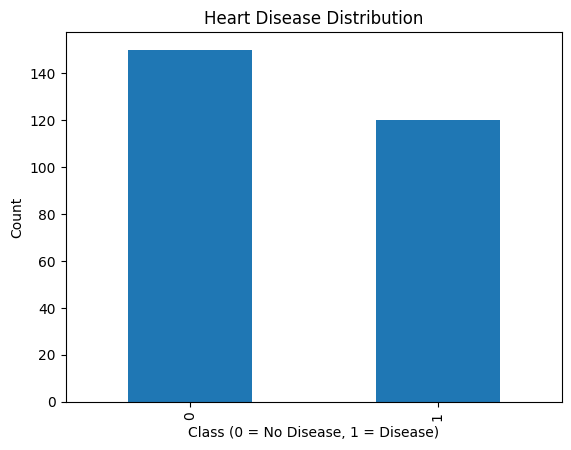

In [8]:
plt.figure()
df["target"].value_counts().plot(kind="bar")
plt.title("Heart Disease Distribution")
plt.xlabel("Class (0 = No Disease, 1 = Disease)")
plt.ylabel("Count")
plt.show()

### Feature Selection

We select a subset of numerical features that are commonly associated with heart disease and separate them from the target variable.

In [9]:
features = [
    "age",
    "cholesterol",
    "bp",
    "max_hr",
    "st_depression",
    "num_vessels"
]

X = df[features].values
y = df["target"].values.reshape(-1, 1)

### Feature Normalization

We standardize the feature values using z-score normalization
(mean = 0, standard deviation = 1). This helps many machine learning algorithms perform better.

In [10]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)

X_norm = (X - X_mean) / X_std

### Stratified Train-Test Split

This function splits the dataset into training and testing sets while
preserving the original class distribution.

In [11]:
def stratified_split(X, y, test_size=0.3, random_state=None):
    rng = np.random.default_rng(random_state)

    pos_idx = np.nonzero(y.flatten() == 1)[0]
    neg_idx = np.nonzero(y.flatten() == 0)[0]

    rng.shuffle(pos_idx)
    rng.shuffle(neg_idx)

    pos_split = int(len(pos_idx) * (1 - test_size))
    neg_split = int(len(neg_idx) * (1 - test_size))

    train_idx = np.concatenate([pos_idx[:pos_split], neg_idx[:neg_split]])
    test_idx = np.concatenate([pos_idx[pos_split:], neg_idx[neg_split:]])

    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

### Final Dataset Split

We apply the stratified split to obtain training and testing datasets.

In [12]:
X_train, X_test, y_train, y_test = stratified_split(
    X_norm,
    y,
    test_size=0.3,
    random_state=42
)

## Step 2: Implement Basic Logistic Regression

### Model and Optimization Definitions
This cell contains the definitions of:
- Regression models (linear, logistic, ridge)
- Activation and cost functions
- Gradient computations
- Gradient descent optimizer

These classes provide the core functionality for training and evaluating models.

In [13]:

class Regression(ABC):
    @staticmethod
    @abstractmethod
    def predict(X, w, b):
        pass

class LinearRegression(Regression):
    @staticmethod
    def predict(X, w, b):
        return X @ w + b

class LogisticRegression(Regression):
    @staticmethod
    def predict(X, w, b):
        z = X @ w + b
        return ActivationFunction.sigmoid(z)

class RidgeRegression(Regression):

    @staticmethod
    def fit_closed_form(X, y, lambda_):
        m, n = X.shape
        I = np.eye(n)
        w = np.linalg.inv(X.T @ X + lambda_ * I) @ X.T @ y
        b = 0.0
        return w, b

class ActivationFunction:
    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

class CostFunction:

    @staticmethod
    def linear_cost(X, y, w, b):
        m = X.shape[0]
        f = X @ w + b
        return (1 / (2 * m)) * np.sum((f - y) ** 2)

    @staticmethod
    def logistic_cost(X, y, w, b):
        m = X.shape[0]
        f = LogisticRegression.predict(X, w, b)

        eps = 1e-8
        f = np.clip(f, eps, 1 - eps)

        return -(1 / m) * np.sum(
            y * np.log(f) + (1 - y) * np.log(1 - f)
        )

    @staticmethod
    def regularized_cost(X, y, w, b, lambda_, logistic=False):
        m = X.shape[0]

        if logistic:
            cost = CostFunction.logistic_cost(X, y, w, b)
        else:
            cost = CostFunction.linear_cost(X, y, w, b)

        reg = (lambda_ / (2 * m)) * np.sum(w ** 2)
        return cost + reg

class Gradient:

    @staticmethod
    def compute_gradient(X, y, w, b, logistic=False, lambda_=0.0):
        m = X.shape[0]

        if logistic:
            f = LogisticRegression.predict(X, w, b)
        else:
            f = LinearRegression.predict(X, w, b)

        error = f - y

        dj_dw = (1 / m) * (X.T @ error)
        dj_db = (1 / m) * np.sum(error)

        dj_dw += (lambda_ / m) * w

        return dj_dw, dj_db

class Optimizer:

    @staticmethod
    def gradient_descent(
        X, y, w_init, b_init,
        alpha, num_iters,
        logistic=False, lambda_=0.0
    ):
        w = w_init.copy()
        b = b_init
        j_history = []

        for _ in range(num_iters):
            dj_dw, dj_db = Gradient.compute_gradient(
                X, y, w, b, logistic, lambda_
            )

            w -= alpha * dj_dw
            b -= alpha * dj_db

            J = CostFunction.regularized_cost(
                X, y, w, b, lambda_, logistic
            )
            j_history.append(J)

        return w, b, j_history


### Model Training
Initialize model parameters and run gradient descent to optimize the logistic regression model. The cost at each iteration is stored in J_history.

In [14]:
w_init = np.zeros((X_train.shape[1], 1))
b_init = 0.0

w, b, J_history = Optimizer.gradient_descent(
    X_train, y_train,
    w_init, b_init,
    alpha=0.01,
    num_iters=1500,
    logistic=True
)

### Cost Convergence
Plot the training cost versus iterations to visualize the convergence of gradient descent. A decreasing curve indicates successful learning.


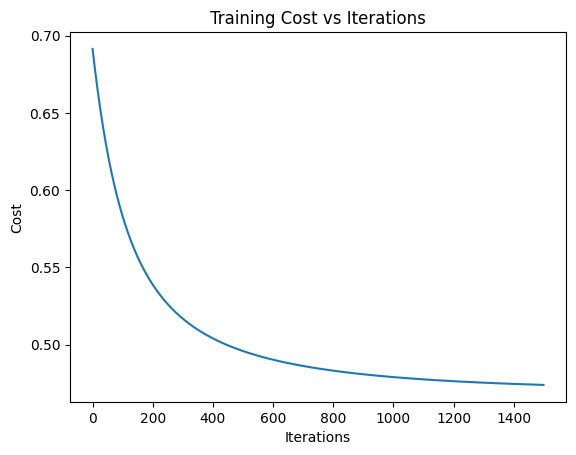

In [15]:
plt.plot(J_history)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Training Cost vs Iterations")
plt.show()

### Evaluation Metrics
Define a helper function `compute_metrics` to calculate accuracy, precision, recall, and F1-score for classification predictions.


In [16]:
def compute_metrics(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    acc = (tp + tn) / len(y_true)
    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)

    return acc, prec, rec, f1

### Model Evaluation
Use the trained logistic regression model to make predictions on the training and test sets. Evaluate performance using accuracy, precision, recall, and F1-score.


In [17]:
y_train_pred = (LogisticRegression.predict(X_train, w, b) >= 0.5).astype(int)
y_test_pred = (LogisticRegression.predict(X_test, w, b) >= 0.5).astype(int)

train_metrics = compute_metrics(y_train, y_train_pred)
test_metrics = compute_metrics(y_test, y_test_pred)

## Step 3: Visualize Decision Boundaries

### Decision Boundary Plotting
Define a function `plot_decision_boundary` to visualize the separation learned by a logistic regression model on two features. This function plots the 0.5 decision boundary and the data points for intuitive inspection.

In [18]:
def plot_decision_boundary(X, y, w, b, feature_names):
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx1, xx2 = np.meshgrid(
        np.linspace(x1_min, x1_max, 200),
        np.linspace(x2_min, x2_max, 200)
    )

    grid = np.c_[xx1.ravel(), xx2.ravel()]
    probs = ActivationFunction.sigmoid(grid @ w + b).reshape(xx1.shape)

    plt.contour(xx1, xx2, probs, levels=[0.5])
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap="coolwarm", alpha=0.7)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.show()

### Logistic Regression on a Feature Pair
Train a logistic regression model using only the features `age` and `cholesterol`.After training, visualize the learned decision boundary on the training data to understand how the model separates the classes in 2D.

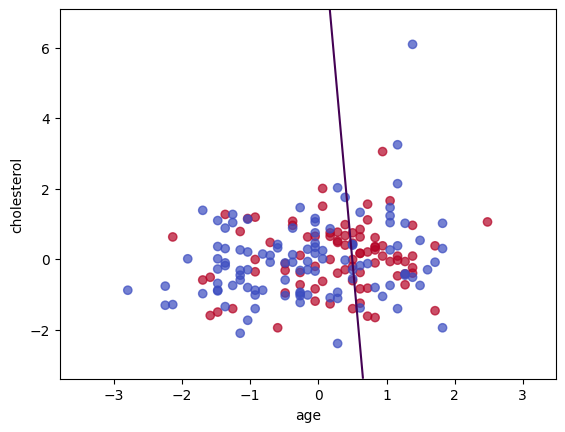

In [19]:
pair = ["age", "cholesterol"]
idx = [features.index(f) for f in pair]

X_pair = X_norm[:, idx]
y_pair = y

X_tr, X_te, y_tr, y_te = stratified_split(X_pair, y)

w_p, b_p, _ = Optimizer.gradient_descent(
    X_tr, y_tr,
    np.zeros((2,1)), 0,
    alpha=0.01,
    num_iters=1000,
    logistic=True
)

plot_decision_boundary(X_tr, y_tr, w_p, b_p, pair)

## Step 4: Repeat with Regularization

### L2 Regularization Sweep
Test different regularization strengths $\lambda$ for logistic regression:
- Train the model with each $\lambda$.
- Compute test metrics: accuracy, precision, recall, and F1-score.
- Store the weight norm to observe how regularization affects model magnitude.
This helps in selecting an appropriate $\lambda$ for balancing generalization and overfitting.


In [20]:
lambdas = [0, 0.001, 0.01, 0.1, 1]
results = []

for l in lambdas:
    w_r, b_r, _ = Optimizer.gradient_descent(
        X_train, y_train,
        np.zeros((X_train.shape[1],1)), 0,
        alpha=0.01,
        num_iters=1500,
        logistic=True,
        lambda_=l
    )

    y_pred = (LogisticRegression.predict(X_test, w_r, b_r) >= 0.5).astype(int)
    acc, prec, rec, f1 = compute_metrics(y_test, y_pred)

    results.append([l, acc, prec, rec, f1, np.linalg.norm(w_r)])


### Effect of Regularization on Metrics and Weight Norm
After sweeping through different L2 regularization strengths $\lambda$, plot:

- Test metrics $accuracy, precision, recall, F1$ vs lambda
- Weight norm $|w|$ vs lambda

This allows us to observe how increasing regularization affects model performance and the magnitude of learned weights.


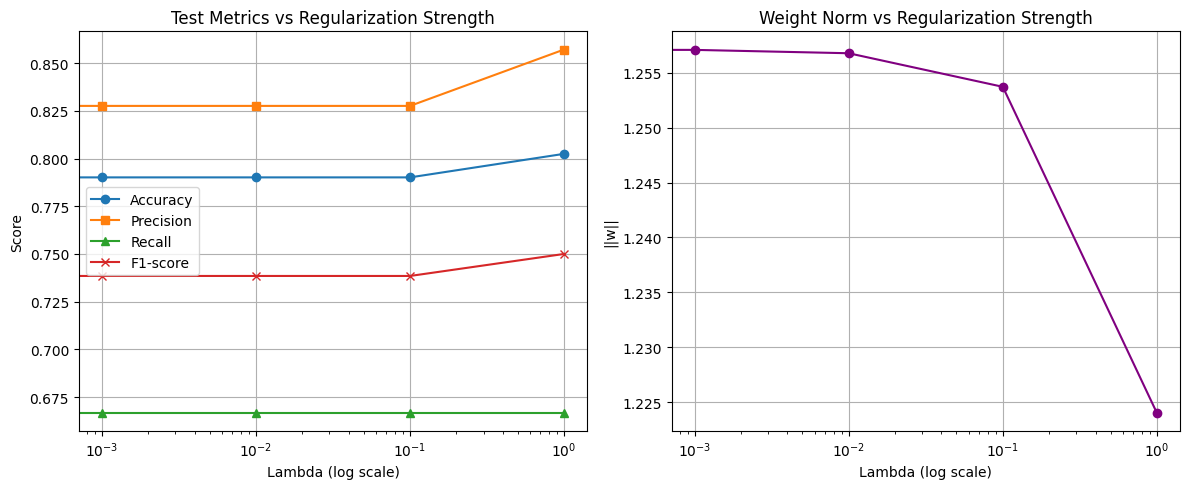

In [21]:
results = np.array(results)  # Convert to NumPy array for easy slicing
lambda_vals = results[:, 0]
accuracy = results[:, 1]
precision = results[:, 2]
recall = results[:, 3]
f1_score = results[:, 4]
weight_norm = results[:, 5]

plt.figure(figsize=(12,5))

# Plot metrics
plt.subplot(1, 2, 1)
plt.plot(lambda_vals, accuracy, marker='o', label='Accuracy')
plt.plot(lambda_vals, precision, marker='s', label='Precision')
plt.plot(lambda_vals, recall, marker='^', label='Recall')
plt.plot(lambda_vals, f1_score, marker='x', label='F1-score')
plt.xscale('log')
plt.xlabel("Lambda (log scale)")
plt.ylabel("Score")
plt.title("Test Metrics vs Regularization Strength")
plt.legend()
plt.grid(True)

# Plot weight norm
plt.subplot(1, 2, 2)
plt.plot(lambda_vals, weight_norm, marker='o', color='purple')
plt.xscale('log')
plt.xlabel("Lambda (log scale)")
plt.ylabel("||w||")
plt.title("Weight Norm vs Regularization Strength")
plt.grid(True)

plt.tight_layout()
plt.show()


## Step 5: Deployment Exploration with Amazon SageMaker

We export the trained model parameters and describe the steps to deploy the model using Amazon SageMaker.